# BlackJack Simulator


# Code Flow :-

1. Import Libraries
2. Define Strategies under Considerations
    - read csv and set index to strategy columns
    - more strateies can be added as a row in the same data frame or via editing the csv at source
    
3. Define the class for BlackJack Simulator
    - This module is the main class definitions of the blackjack game simulator
    - please refer the cell for function level comments
4. Identify Point of Convergence
    - This module is used to identify the number of iterations required to achive convergence for "No Strategy"
    - Steps:
      - create an instance of Black_jack_simulator
      - Run 10000 simulation for "No Strategy" by calling "run" function. refer cell for more details
      - Identify point of convergence based on the defined eplison change threshold of 0.01. please refer cell for more details
      - decide any buffer to add over convergence point to account of performance variance in other strategies.
        - 1600(point of convergence) + 400(buffer)
5. Strategy Analysis
    - This module covers the indepth simulation performance analysis
    - Steps:
        - for visualization purposes : run a single instance of 2000 simulations of all Strategies, as described in the convergence idnetification stage.
        - run 30 instance of 2000 simulations of all strategies and record the expected winnings at the end of each instance in distributions dataframe. please refer the cell for more details
        - visualize the distribution data frame
        - Run One way anova for each strategy with "No Strategy" and record log
            - identify if statistically significant differances in expected winnings
            
        - visualize means, standard deviations and quantile of expected winnings for each strategy based on the instances.
        - conclude
            
        
      

## 1. Import Libraries

In [2]:
#Import Libraries

import random
import pandas as pd
import numpy as np
import plotly.express as px
import pandas as pd
from scipy.stats import f_oneway
import plotly.offline as pyo
pyo.init_notebook_mode()

## 2. Define Strategies under Consideration

In [3]:

#reading Strategy csv
df=pd.read_csv('strategies.csv')
df.set_index('Strategy',inplace=True)
df

2  3  4    5  6    7  8    9  10  J  Q  K  A  Ace
Strategy                                                        
K-O          1.0  1  1  1.0  1  1.0  0  0.0  -1 -1 -1 -1 -1   -1
Hi-Lo        1.0  1  1  1.0  1  0.0  0  0.0  -1 -1 -1 -1 -1   -1
Hi-Opt I     0.0  1  1  1.0  1  0.0  0  0.0  -1 -1 -1 -1  0    0
Hi-Opt II    1.0  1  2  2.0  1  1.0  0  0.0  -2 -2 -2 -2  0    0
KISS         0.0  0  1  1.0  1  0.0  0  0.0  -1 -1 -1 -1  0    0
Zen          1.0  1  2  2.0  2  1.0  0  0.0  -2 -2 -2 -2 -1   -1
Omega II     1.0  1  2  2.0  2  1.0  0 -1.0  -2 -2 -2 -2  0    0
Red 7        1.0  1  1  1.0  1  0.0  0  0.0  -1 -1 -1 -1 -1   -1
Wizard Ace   0.0  0  0  1.0  0  0.0  0  0.0   0  0  0  0 -1   -1
Halves       0.5  1  1  1.5  1  0.5  0 -0.5  -1 -1 -1 -1 -1   -1
No Strategy  0.0  0  0  0.0  0  0.0  0  0.0   0  0  0  0  0    0

## 3. Define the class for BlackJack Simulator

- Commented code

In [4]:
#Define class Blackjack Simulator

class Black_jack_simulator(object):
    def __init__(self):
        self.card_list_base = ['2','3','4','5','6','7','8','9','10','J','Q','K','A']*4
        self.card_values = {'J': 10, 'Q': 10, 'K': 10, 'A': 11, 'Ace': 1,'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, 
             '9': 9, '10': 10}
        
        

#To generate a deck of cards        
    def generating_deck(self,y=1): 
        self.card_list = self.card_list_base*y
        np.random.shuffle(self.card_list)
        return self.card_list
    
    

#A card is picked from available cards
    def get_card(self,x, y=1): 
        for i in range(y):            
            x.append(self.card_list.pop())
        return x

#Total value of cards is calculated  
    def check_total(self,x): 
        return int(sum(self.card_values[i] for i in x))

#A can be replaced by Ace
    def ace(self,x): 
        if 'A' in x:
            x[x.index('A')] = 'Ace'
            return True, x        
        return False,x


#Counting strategy defines weightage to each card and total running count is calculated
    def counting(self,x, game_type):        
        return sum([ df.loc[game_type][i] for i in x])

#Running count is adjusted    
    def counting_adj(self, running_count):
        try:
            
            ret =  round(running_count/(len(self.card_list)//52))
        except Exception as e:
            ret = running_count
        
        return ret
        
        
#Player function determines if the player if hit or stay

    def player_function(self,player, true_count, dealer):        
        check_total_player = self.check_total(player)
        

        if true_count < 0:
            if check_total_player <= self.threshold:
                ret =  1
            else:
                ret =  0        
        
        elif true_count > 0:
            if check_total_player >= self.threshold:
                ret = 0
            else :
                ret = 1

        else:
            if check_total_player >= 17:
                ret = 0
            else:
                ret = 1
        
        return ret
      
# update running count and calculate true count based in the game strategy and open cards        
    def update_running_true_count(self,running_count,x,game_type):
        
        running_count += self.counting(x, game_type)
        true_count = self.counting_adj( running_count)
        return running_count,true_count
        

#Dealer function determines dealer's next steps and logs outcome of the game    
    
    def dealer_function(self,player, dealer, t, dt, 
                        running_count, true_count, game_type, current=True): 
        # initialize win, draw and losses to 0
        w,d,l = 0,0,0

        
        # run the roll till roll ends 
        while current:
            # calulate player total 
            t  = self.check_total(player)
            
            
            
            # when player goes bust
            if t > 21: 
                check_ace_player,player = self.ace(player)
                t = self.check_total(player)
                continue
            
            # calcualte dealer total
            dt = self.check_total(dealer)#player)
            
            # following basic strategy for dealer, that is hit till total is less than 17
            while dt <= 16: 
                self.get_card(dealer)
                dt = self.check_total(dealer)
                
                running_count,true_count =self.update_running_true_count(running_count,dealer[-1:],game_type)
                
                
                
                
            if dt > 21: # dealer is bust
                
                check_ace, dealer = self.ace(dealer)
                                
                if check_ace:
                    continue
                else:
                    w += 1
                    break                
                
                
            elif dt == 21: #dealer has blackjack
                if dt == t: # Player too has blackjack!
                    d += 1
                else:
                    l += 1
                break



            elif 17 <= dt < 21: # dealer basic strategy stop

                if dt < t: # if player's value is more
                    if t == 21: # player has blackjack
                        w +=3/2
                    else:
                        w += 1
                    break
                    
                elif dt > t: # dealer has higher value
                    l += 1
                    break                    
                    
                elif dt == t: # player and dealer draws
                    d += 1
                    break
                else:
                    w += 1
                    break
        return [w, l, d, running_count, true_count]
    

    
    # simulation of a single roll
    def game(self,  running_count, true_count, game_type):
        
        # first 2 cards dealt to dealer and player
        player,dealer = self.get_card([], 2),self.get_card([], 2)

        
        # initialize win, draw and losses
        w,d,l = 0,0,0
        
        # start counting, players open card and dealers one face up card, based on strategy
        running_count,true_count =self.update_running_true_count(running_count,(player+dealer[:1]),game_type)
                
        
        
        # play the roll untill roll ends ( as a part of break) or no more cards left to deal
        while len(self.card_list) > 1:
            
            # calculate player and dealer total
            check_total_player,check_total_dealer = self.check_total(player),self.check_total(dealer)
            

            # check if both player and dealer have a blackjack initially
            if check_total_player == 21 and check_total_dealer == 21:
                
                # add the remaining card of the dealer to counting
                running_count,true_count =self.update_running_true_count(running_count,
                                                                         (dealer[-1:]),game_type)
        
                # draw          
                d += 1
                break
                
            # check of player has a black jack and dealer does not    
            elif check_total_player == 21 and check_total_dealer < 21:
                
                running_count,true_count =self.update_running_true_count(running_count,
                                                                         (dealer[-1:]),game_type)
                         
                # player wins
                w += 3/2
                
                
                break
                
                
            #player based on the trategy make a choice to the game  
            player_input = self.player_function(player, true_count, dealer)            
            
            # assume player is not bust
            player_bust = False
            
            
            
            
            # player plays if the strategy recommends to play, till there are cards left in the deck and player is not bust
            while (player_input == 1) and (len(self.card_list) > 1) and not(player_bust):
                
                
                # player hits
                self.get_card(player)
            
            
                # calculate player total
                t = self.check_total(player)

                running_count,true_count =self.update_running_true_count(running_count,
                                                                         (player[-1:]),game_type)                

                
                
                
                # continue playing if player is not bust 
                
                if t < 21: continue                
                
                elif  t > 21: # if players value is higher than 21
                    
                    # adjust the value of ace is in player open cards
                    check_ace_player,player =self.ace(player)
                    
                    # if adjusted, than re calculate player total
                    if check_ace_player: 
                        t = self.check_total(player)
                        continue
                    else: # if not able to adjust then player went bust                   
                        l += 1
                        player_bust = True

                elif t == 21:    # blackjack!        
                    w += 1
                    break
                
                
                # recheck strategy recommendation
                player_input = self.player_function(player, true_count, dealer)
                            
            if player_bust: # if bust then end the roll
                break
                    
                    
                    
                    
            if player_input == 0: # if player stays then its dealers turn
                
                # calulcate player and dealer total
                t,dt  = self.check_total(player),self.check_total(dealer)
                
                
                
                # dealers turn and game decision
                observation = self.dealer_function(player, dealer, t, dt, running_count, true_count, game_type)
                
                
                
                # update loss win and draws based on the roll
                l += observation[1]
                w += observation[0]
                d += observation[2]
                
                
                
                # update running count and true count based on dealer's turn
                running_count,true_count  = observation[3:5]
                
                break

        return [w, l, d, running_count, true_count]  
    


    
    
#Simulation of a single game with multiple rolls     
    def start_game(self, game_type,rec,use_rec=False):
        self.card_list = self.generating_deck(6)
        
        
        # Initialze win draw loss and number of total rolls played
        w,d,l,n = [],[],[],0
        
        # initialize running count and true count
        running_count,true_count = 0,0

        while True: # play until game ends
            
            
            
            # run one roll
            roll = self.game( running_count, true_count, game_type)
            
            
            
            # update wins, losses, draws based on the most recent roll
            (w.append(roll[0]),l.append(roll[1]),d.append(roll[2]))
            
            
            # increment number of rolls
            n += 1

            
            # update running count and true count based on the most recent roll
            running_count,true_count = roll[3:5]

            
            # if the number of cards left is less than 12 after playing the most recent roll then end the game.
            if len(self.card_list) < 12:
                break        
        
        
        # Return wins, draw, losses and total rolls player in the game
        if use_rec:
            return {'wins':sum(w[-rec:]),'draws': sum(d[-rec:]),'losses': sum(l[-rec:]),'n': rec}#n}    
        else:
            return {'wins':sum(w),'draws': sum(d),'losses': sum(l),'n': n}#n}    
    

    
# main simulation function    
    def run(self, simulations, df):

        
        # initilize based simulation parameters
        observations     = {}
        observations_df = []
        total_winnings     = 0
        runs  = 0
#        simulations    = 1000
        rec   = 10
        self.threshold        = 16
        game_types   = list(df.index) # createa list of strategies present in the input dataframe


        # loop through each strategy for simulation
        for i in game_types:
            print(f"Initiating blackjack with strategy:  {i}")
            
            
            t0 = simulations
            
            
            # createa a simulation dataframe ,with the configured number of simulation record index
            simulation_df = pd.DataFrame({'sim':list(range(simulations))})
            
            # for each index run a simulation
            simulation_df_g = pd.DataFrame.from_records(simulation_df.sim.apply(lambda x: self.start_game(i,rec,use_rec=False)).values


                                                       )

            # calculate simulation statistics 
            simulation_df_g['assumed_winning'] = simulation_df_g['wins'] + simulation_df_g['draws']
            simulation_df_g['total_winning'] = simulation_df_g['assumed_winning'].cumsum()
            simulation_df_g['total_runs'] = simulation_df_g['n'].cumsum()
            simulation_df_g['stats'] = np.around((simulation_df_g['total_winning']/simulation_df_g['total_runs']
                                                )*100,4)

            # mention strategy name associated with simulations
            simulation_df_g['game_types'] = str(i)

            
            # append the simulation dataframe in the observations df list
            observations_df.append(observations)
            
            
            # add the expectations of the strategy to observations dict
            observations[f"{i}"] = simulation_df_g['stats'].values
            
            print(f"\nCompleted {i}\n")
            
            
            
            if i == game_types[-1]:
                print(f"Simulation complete {simulations} times")

        # convert observations dict to dataframe, containing expectations of each strategy
        self.obs =  pd.DataFrame(observations)        
        
        
    #plot a line graph for the oservations
    def plot_obs(self):
        try:
            return pyo.iplot(px.line(self.obs))
        except :
            return "NA"
    
    
        
    
    
    

## 4. Identify Point of Convergence

In [5]:
Black_jack_simulator_instance_2 = Black_jack_simulator()

sim = 10000

Black_jack_simulator_instance_2.run(sim,df[df.index=='No Strategy'])

Initiating blackjack with strategy:  No Strategy

Completed No Strategy

Simulation complete 10000 times


In [6]:
Black_jack_simulator_instance_2.obs.to_csv('no_strategy_10k_sim.csv')

In [7]:
Black_jack_simulator_instance_2.plot_obs()

- output

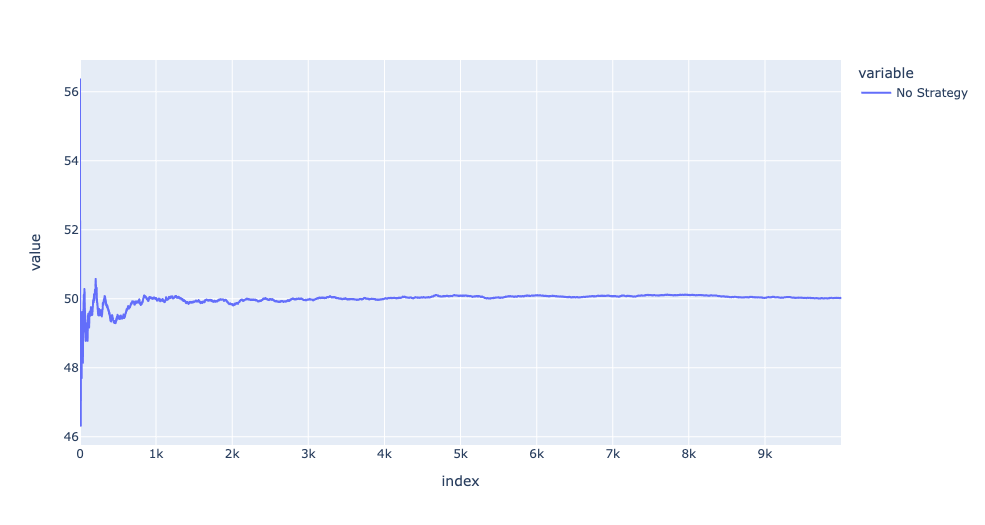

### Idenfying point of convergence

In [8]:

# setting delta number of consecutive records for comparison
delta = 200
# setting epsilon change threshold
eplison = 0.01
for i in range(delta,sim+1-delta,delta): # incrementing iter by delta 
    
    # calculating absolute difference between expected win of current delta iterations with the next iterations 
    diff =  abs(Black_jack_simulator_instance_2.obs['No Strategy'][i-delta:i].mean() -
                Black_jack_simulator_instance_2.obs['No Strategy'][i:i+delta].mean())

    if diff <eplison: # check if the difference is less than threshold epsilon change
        print(i,diff)
        break # if yes then break
        

2600 0.00822200000001061


## 5. Strategy Analysis

In [ ]:

# single run of 2000 simulations of all strategies. 
Black_jack_simulator_instance_1 = Black_jack_simulator()

sim = 1600 +400

Black_jack_simulator_instance_1.run(sim,df)

#result from one simulation
pyo.iplot(px.line(Black_jack_simulator_instance_1.obs),filename = 'simulation_results')

Initiating blackjack with strategy:  K-O

Completed K-O

Initiating blackjack with strategy:  Hi-Lo

Completed Hi-Lo

Initiating blackjack with strategy:  Hi-Opt I

Completed Hi-Opt I

Initiating blackjack with strategy:  Hi-Opt II

Completed Hi-Opt II

Initiating blackjack with strategy:  KISS

Completed KISS

Initiating blackjack with strategy:  Zen

Completed Zen

Initiating blackjack with strategy:  Omega II


- output

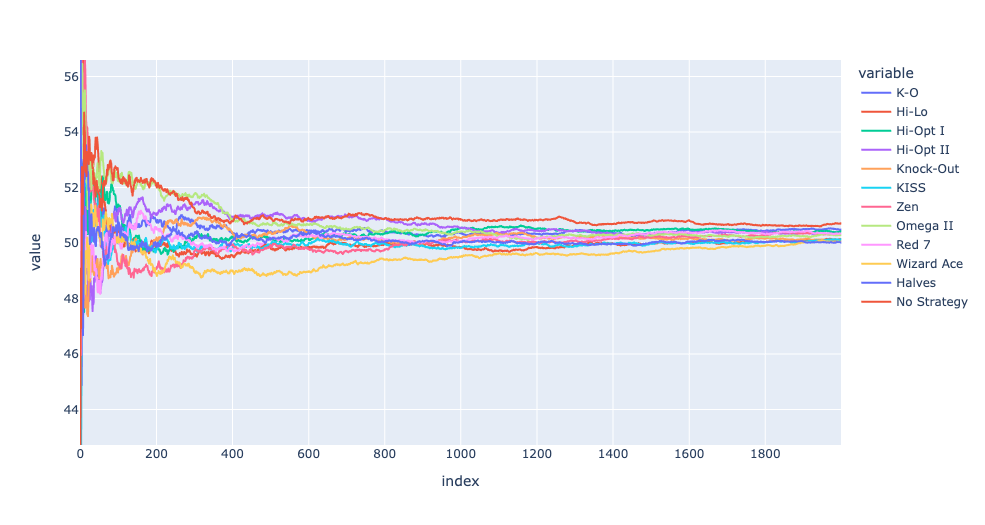



In [ ]:
#save single simulation records
Black_jack_simulator_instance_1.obs.to_csv('single_inst_2k_sim_all_strat.csv')    

In [ ]:

# init an empty distributions list
distributions_list = []

for i in range(30): # run simulation 30 times
    
    
    # create an instance of simulator
    Black_jack_simulator_instance_1 = Black_jack_simulator()
    
    
    # run simulations
    Black_jack_simulator_instance_1.run(2000,df)

    
    # record the last winning estimates for the current run of simulations
    selected = Black_jack_simulator_instance_1.obs.iloc[-1,:]
    
    # record instance number
    selected['set_number'] = i
    
    
    # append in the distribution list
    distributions_list.append(selected)
    

#convert the distribution list in a dataframe and save it
Distribution_df = pd.DataFrame(distributions_list)
    
Distribution_df.to_csv('Black_Jack_dist.csv')    

In [ ]:
#display distribution df
display(Distribution_df)


- output
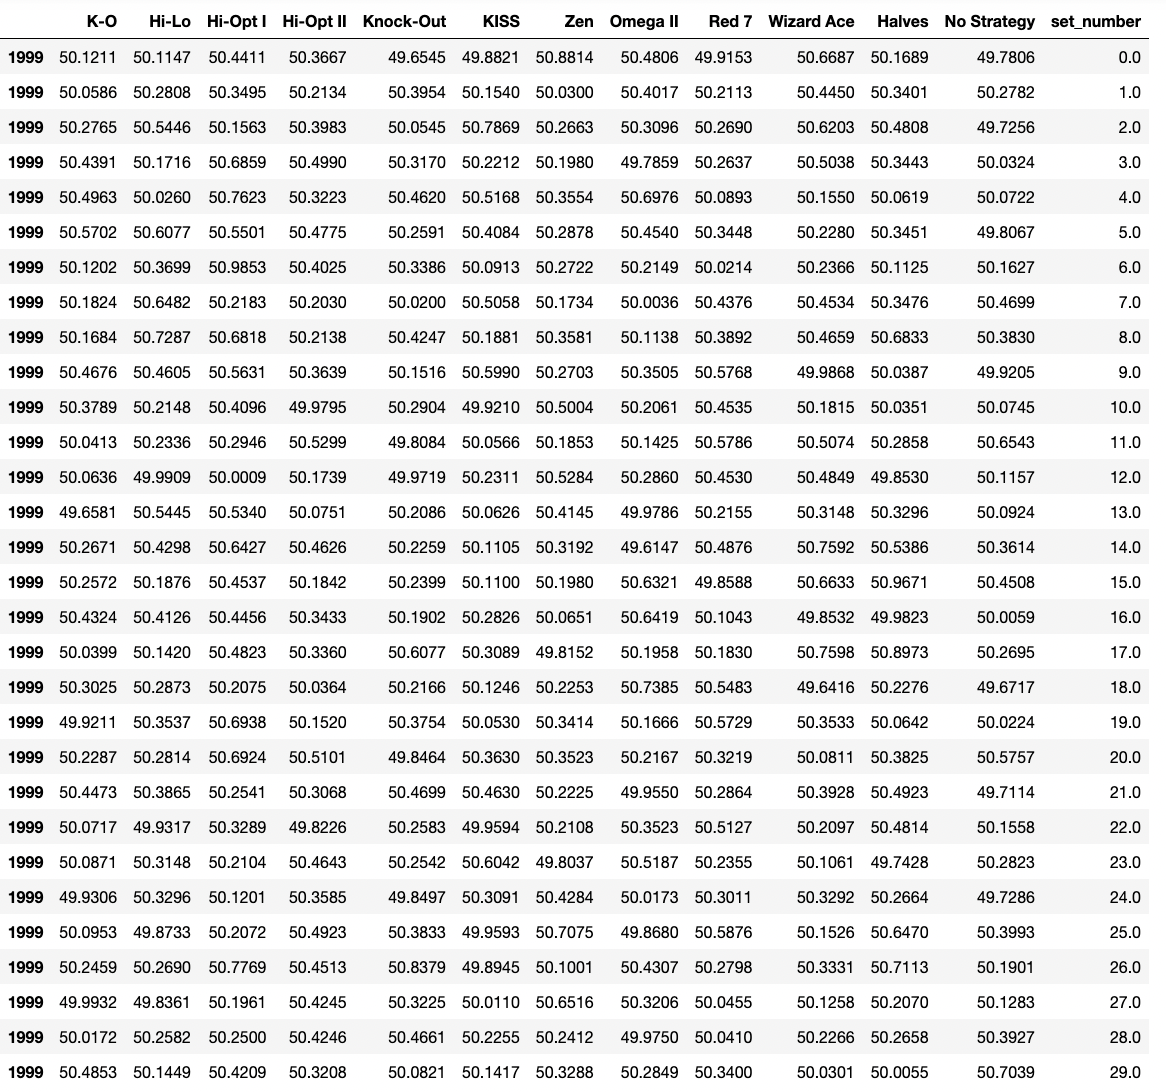

### Anova One Way Test

In [ ]:

# create empty anova list
anova_list = []

for i in Distribution_df.columns: # iterate through each strategy

    # run one way anova with the current index strategy iwth No strategy
    F,p = f_oneway(Distribution_df[i],Distribution_df['No Strategy'] )
    
    #append results to list
    anova_list.append({'strategy':i,'F':F,'p-value':p,'different':p<0.05})
    
#convert to df
anova_df=pd.DataFrame(anova_list)


anova_df=anova_df[anova_df['strategy']!='set_number']
display(anova_df.sort_values('p-value').style.background_gradient(cmap ='coolwarm_r',axis=0))
    
    

- output
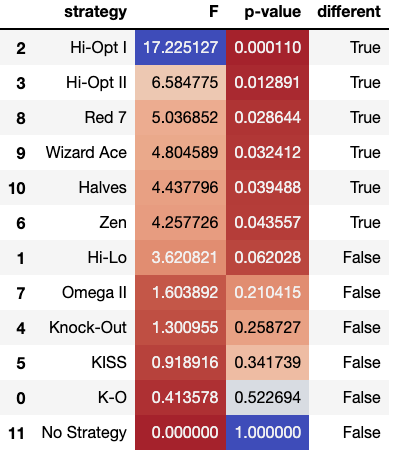

In [ ]:
#Display average expected winnings per strategy after 30 instance of simmulations

display(Distribution_df.mean(axis =0).to_frame().T[pd.DataFrame(anova_list).sort_values('p-value',ascending =False).strategy
               
               ].drop('set_number',axis =1).style.background_gradient(cmap ='coolwarm_r',axis=None))

- output
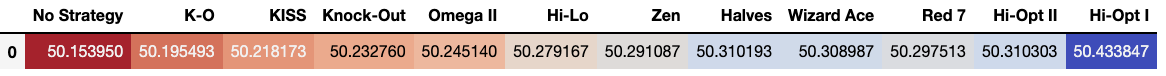

In [ ]:
#Display standard deviations of expected winnings per strategy after 30 instance of simmulations

display(Distribution_df.std(axis =0).to_frame().T[pd.DataFrame(anova_list).sort_values('p-value',ascending =False).strategy
               
               ].drop('set_number',axis =1).style.background_gradient(cmap ='coolwarm_r',axis=None))

- Output
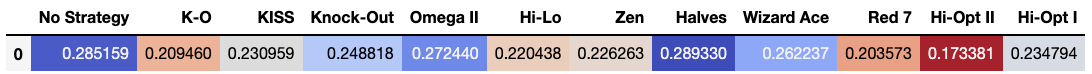

In [ ]:

# display the quantile bounds of expected winnings for each strategy after 30 instances of simulations

display(Distribution_df.quantile([0,0.25,0.5,0.75,1],axis =0)[pd.DataFrame(anova_list).sort_values('p-value',ascending =False).strategy
               
               ].drop('set_number',axis =1).style.background_gradient(cmap ='coolwarm_r',axis=None))




- output
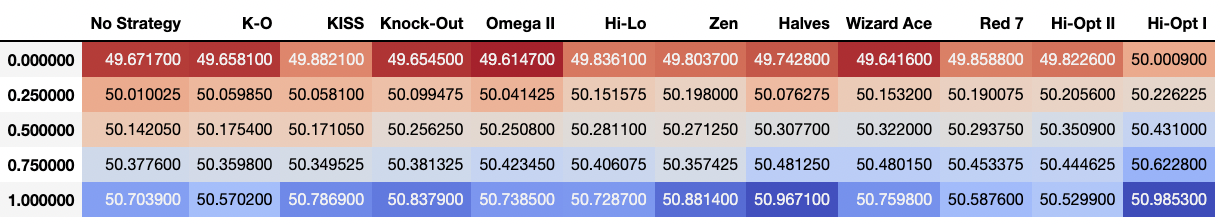

In [ ]:

# show distributon as box plot for comparison
Distribution_df[pd.DataFrame(anova_list).sort_values('p-value',ascending =False).strategy
               
               ].drop('set_number',axis =1).plot(kind='box',figsize = [15,5])

- Output

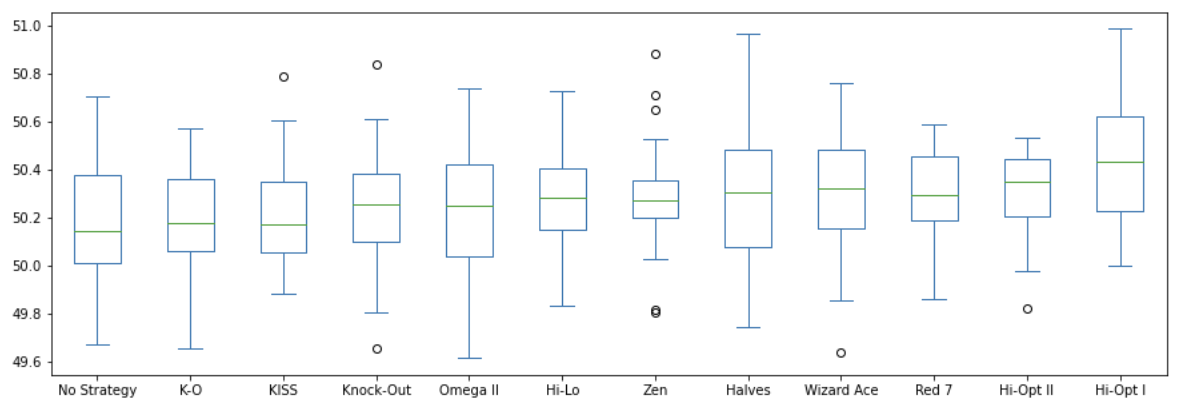